## Generate Spectrograms

This script loads each recording and calculates spectrograms of the time series. Specifically, five consecutive thirty-second blocks of data are selected (from both channels) and the spectrograms are calculated on each 30 second block (for each channel).

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import pandas as pd
import os
import glob
from scipy.signal import spectrogram
import pickle
import random
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.display import specshow
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings("error")

Define some constants

In [69]:
#all EEG data is 100Hz sampling rate
FS = 100

#length of spectrogram in seconds
SPEC_LEN = 30

#define the data directory
data_dir = 'D:\\Sleep Stage Scoring\\lstm-cnn-eeg-sleep-staging\\data'

#define Mel Spectrogram parameters
n_fft = 256
hop_length = 64
n_mels = 64

Define a function to get the most frequent label within a 30-second block, if there are multiple labels. The most frequent label will apply to the entire block.

In [70]:
def get_most_frequent_label(labels):
    unique_labels = np.unique(labels)
    label_counts = {}
    for unique_label in unique_labels:
        label_counts[unique_label] = sum(labels==unique_label)

    most_frequent_label = unique_labels[0]
    for key, value in label_counts.items():
        if value > label_counts[most_frequent_label]:
            most_frequent_label = key

    return most_frequent_label


Define a function to do the spectrogram calculations

In [71]:
def calculate_spectrograms(pkl_files, data_group):
    #store sets of 5 spectrograms and corresponding labels
    spectrogram_list = []
    labels_list = []
    do_plot = True

    for pkl_file in pkl_files:
        df = pd.read_pickle(pkl_file)
        spectrogram_list_tmp = []
        labels_list_tmp = []

        #load 5 thirty-second blocks of EEG data and corresponding labels
        #apply bandpass filters on each block, and then calculate the spectrogram
        #define the label of that window to the be the majority label if there are multiple labels
        ind = 0
        while(ind < len(df)):
            #grab 30 seconds of data
            df_tmp = df.iloc[ind:ind+FS*SPEC_LEN]
            ch1_tmp = df_tmp['EEG Fpz-Cz'].values
            ch2_tmp = df_tmp['EEG Pz-Oz'].values
            label_tmp = get_most_frequent_label(df_tmp['label'].values)

            #subtract mean, unit variance
            #sometimes there is garbage data that is flatlined constant, in which case the std is zero
            #catch the warning and throw away the whole 5 block group
            try:
                ch1_tmp = (ch1_tmp-np.mean(ch1_tmp))/np.std(ch1_tmp)
                ch2_tmp = (ch2_tmp-np.mean(ch2_tmp))/np.std(ch2_tmp)
            except Exception as e:
                spectrogram_list_tmp = []
                labels_list_tmp = []
                ind = ind + FS*SPEC_LEN
                continue
                
            #calculate mel spectrograms
            # Sxx1 = melspectrogram(ch1_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            # Sxx1 = power_to_db(Sxx1, ref=np.max)

            # Sxx2 = melspectrogram(ch2_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            # Sxx2 = power_to_db(Sxx2, ref=np.max)

            # Calculate mel spectrograms for channel 1
            Sxx1 = melspectrogram(y=ch1_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            Sxx1 = power_to_db(Sxx1, ref=np.max)

            # Calculate mel spectrograms for channel 2
            Sxx2 = melspectrogram(y=ch2_tmp, sr=FS, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            Sxx2 = power_to_db(Sxx2, ref=np.max)

    
            if do_plot and (ind == FS * SPEC_LEN * 5):
                do_plot = False
            fig, ax = plt.subplots(figsize=(10, 6))
            ax1 = plt.subplot(211)
            sns.heatmap(Sxx1, cmap="viridis", ax=ax1)  # Use Seaborn to create a heatmap

            fig.colorbar(ax1.get_children()[0], ax=ax1, format="%+2.f dB")
            plt.ylabel('Frequency (Hz)\nCh1')
            ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
            sns.heatmap(Sxx2, cmap="viridis", ax=ax2)  # Use Seaborn to create a heatmap

            fig.colorbar(ax2.get_children()[0], ax=ax2, format="%+2.f dB")
            plt.ylabel('Frequency (Hz)\nCh2')
            plt.xlabel('Time (Seconds)')
            plt.tight_layout()
            plt.savefig('spectrogram.png', dpi=150)
            plt.show()

            spectrogram_list_tmp.append((Sxx1, Sxx2))
            labels_list_tmp.append(label_tmp)
            ind = ind + FS*SPEC_LEN

            if len(spectrogram_list_tmp) == 5:
                #package this result, only if there are no -1 labels
                if -1 not in labels_list_tmp:
                    spectrogram_list.append(spectrogram_list_tmp)
                    labels_list.append(labels_list_tmp)

                spectrogram_list_tmp = []
                labels_list_tmp = []


    #save the results
    pickle.dump(spectrogram_list, open('X_%s_spec.pkl' % data_group, 'wb'))
    pickle.dump(labels_list, open('y_%s.pkl' % data_group, 'wb'))

Do the spectrogram calculations by train, test, and validation sets

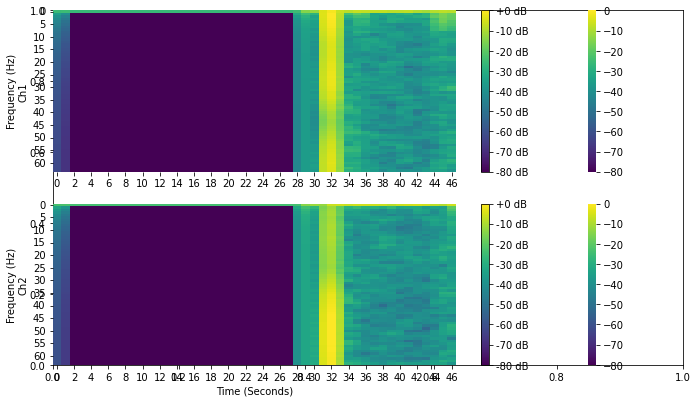

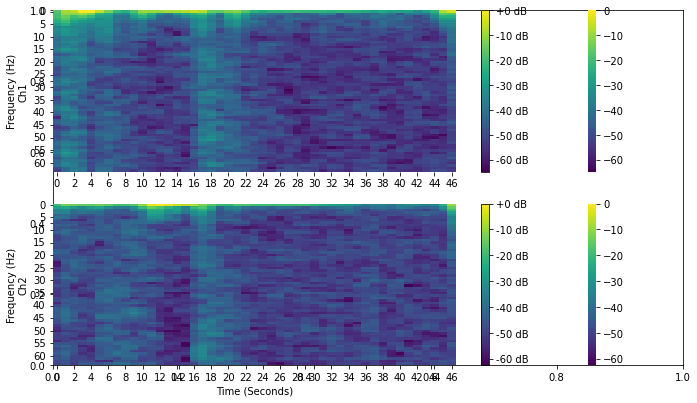

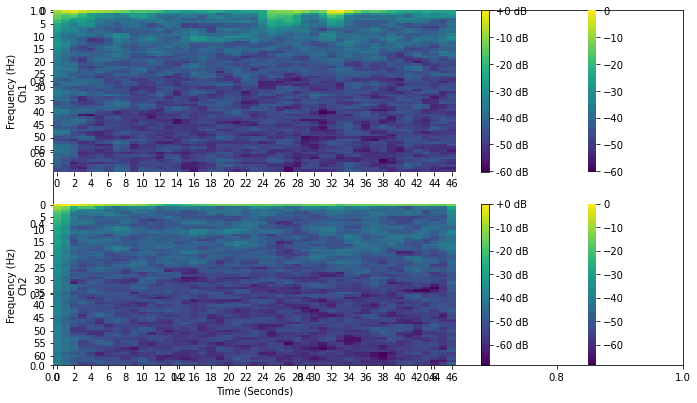

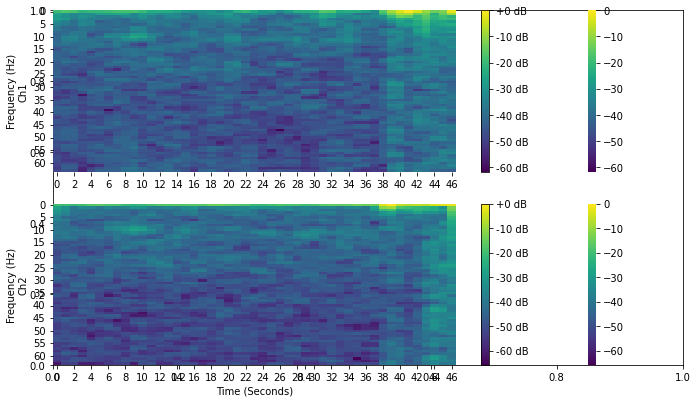

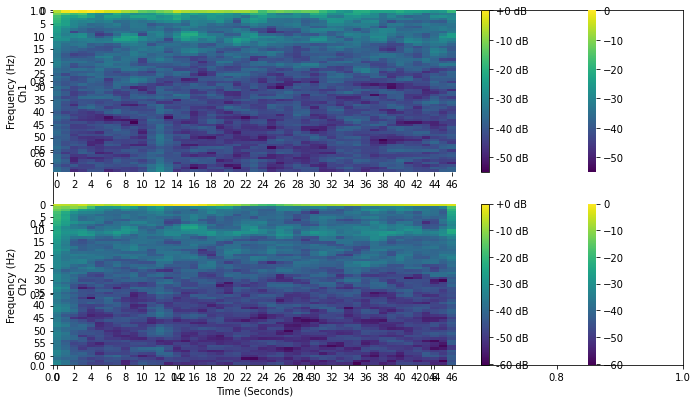

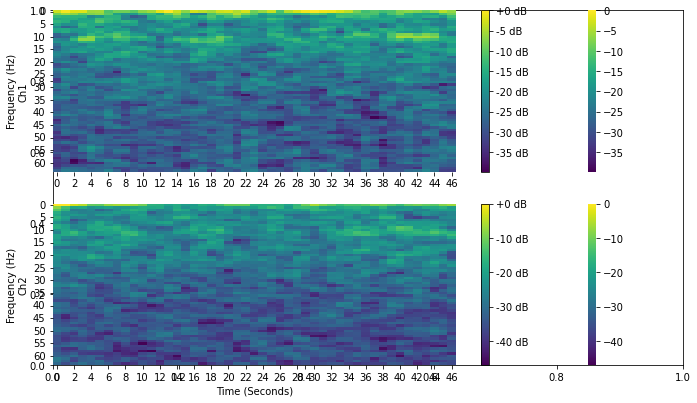

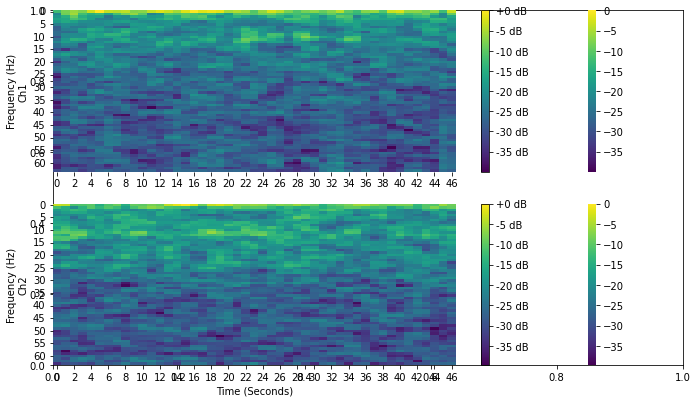

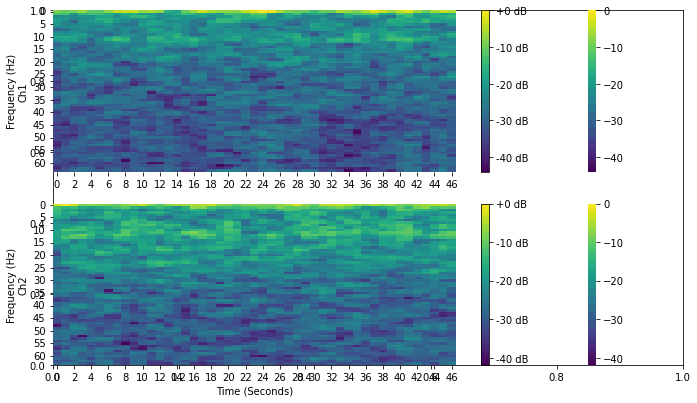

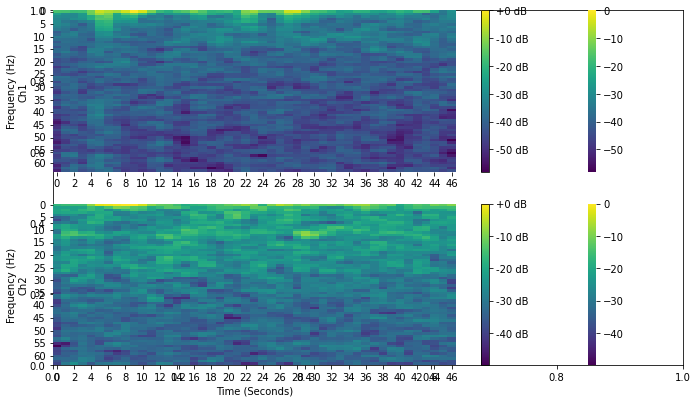

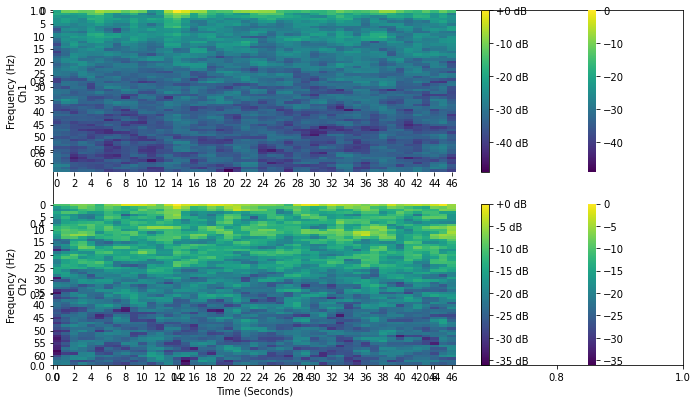

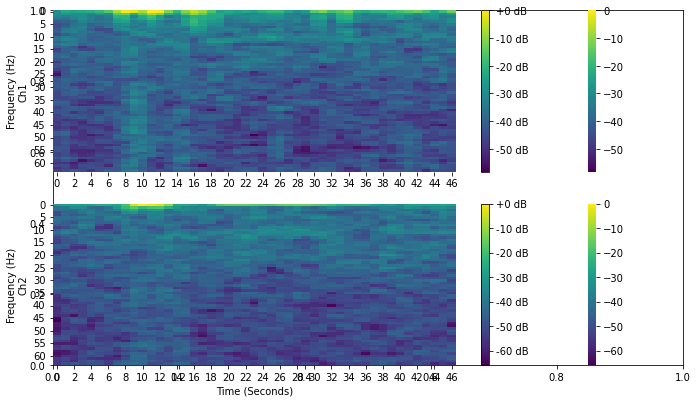

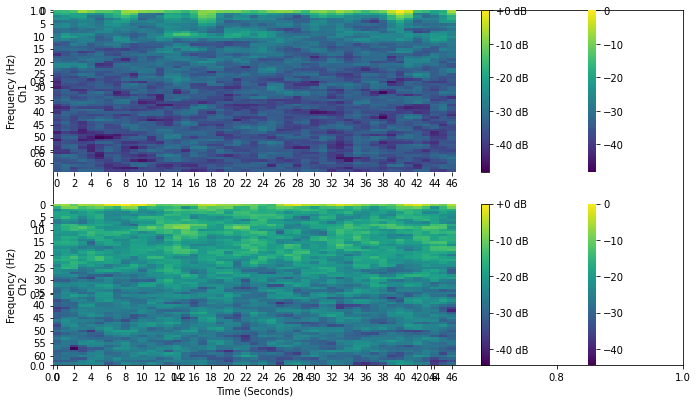

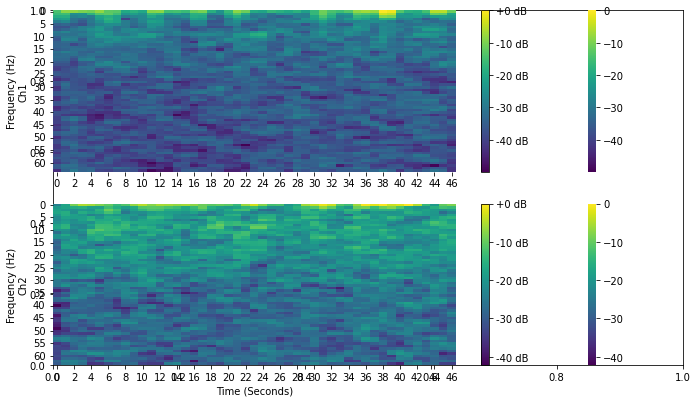

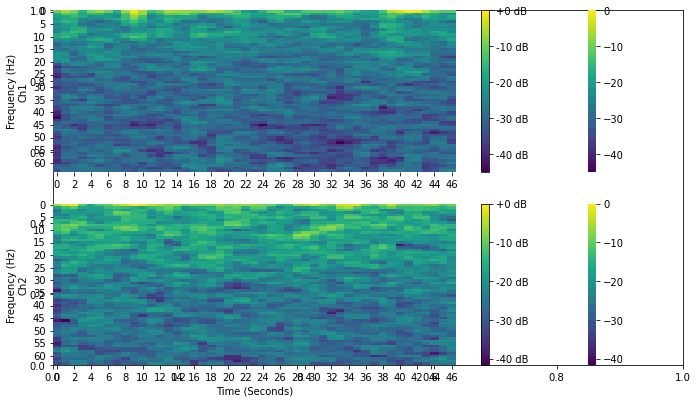

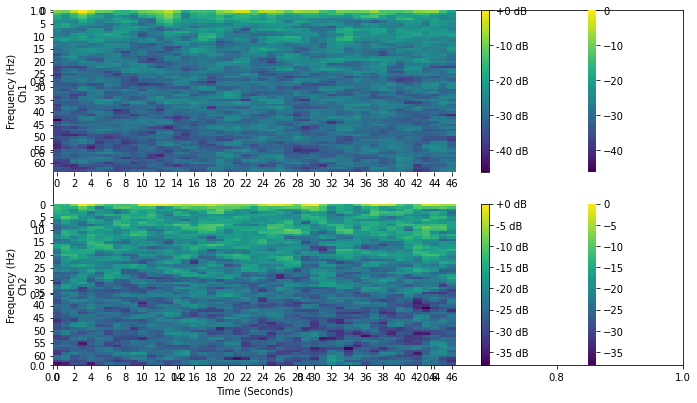

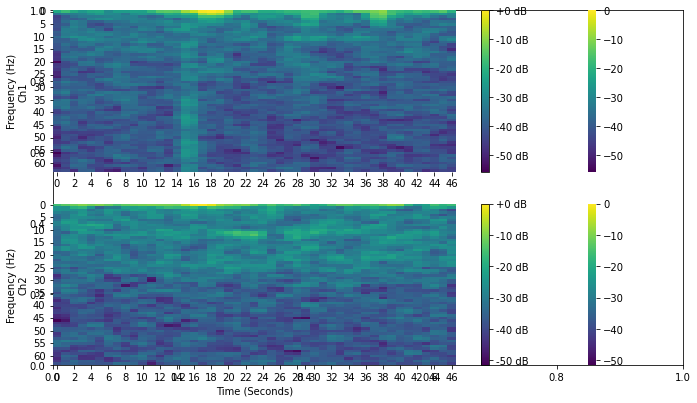

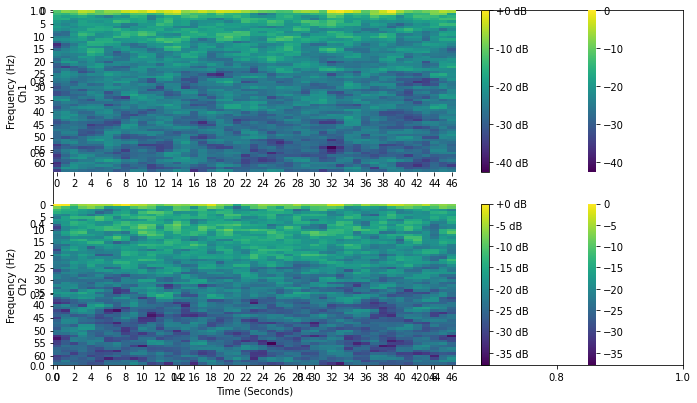

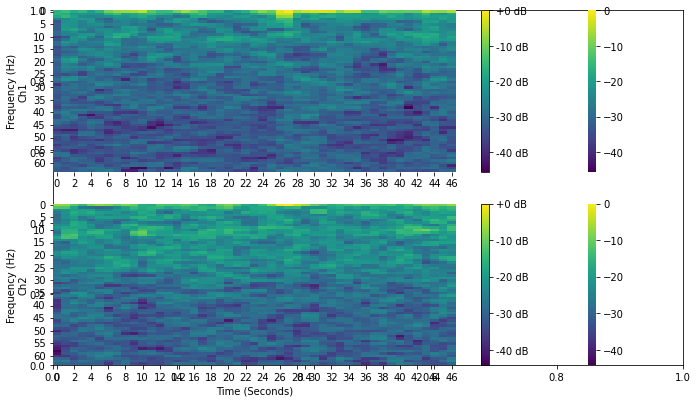

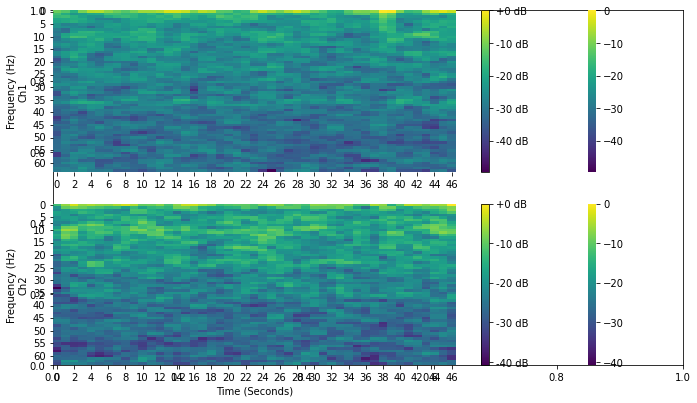

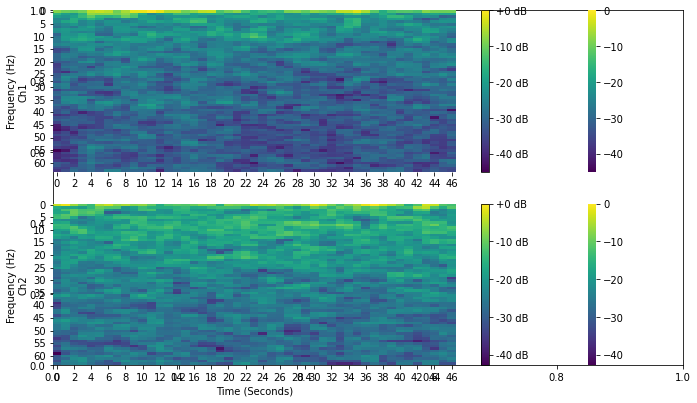

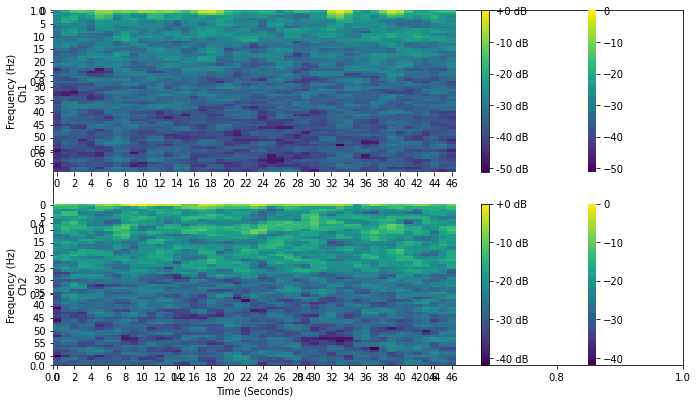

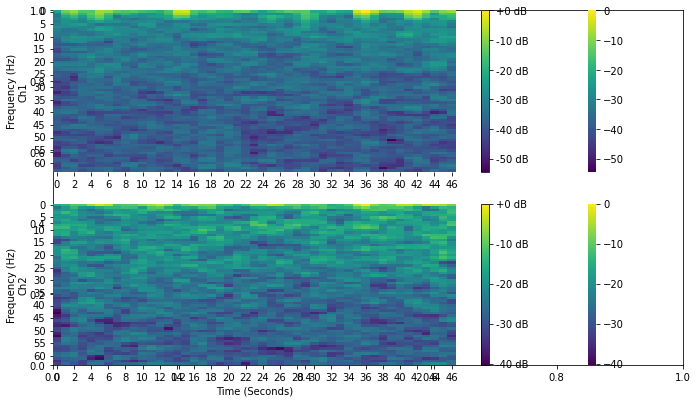

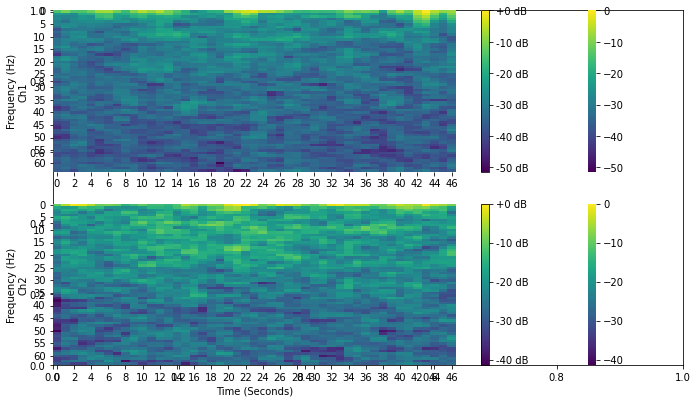

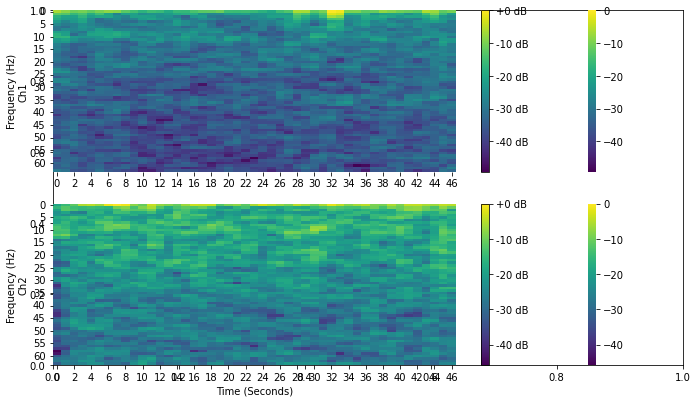

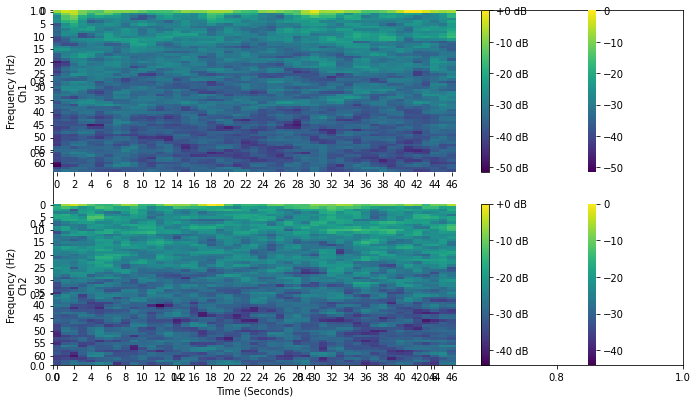

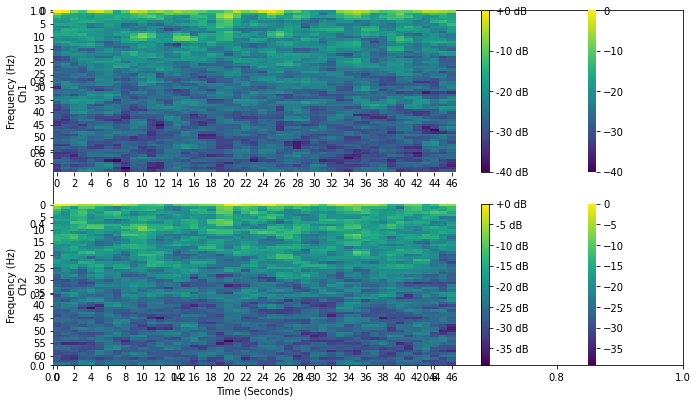

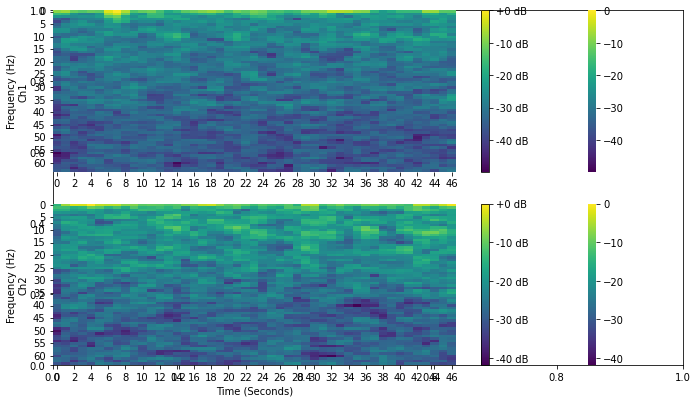

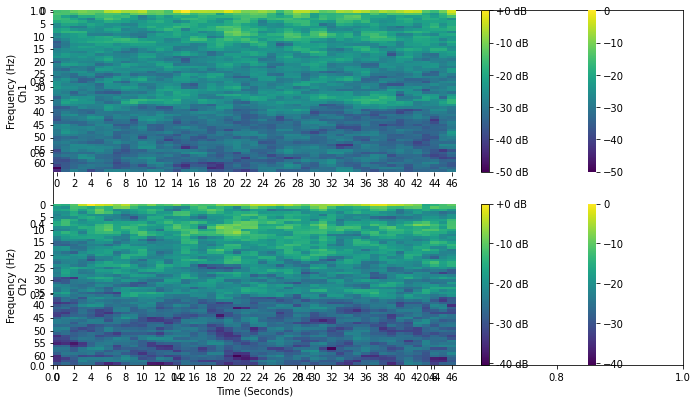

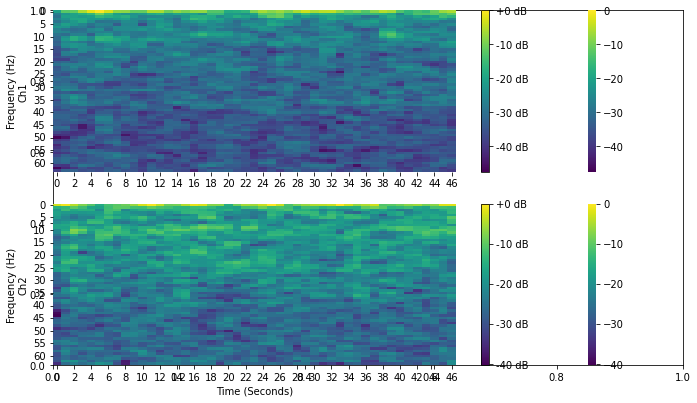

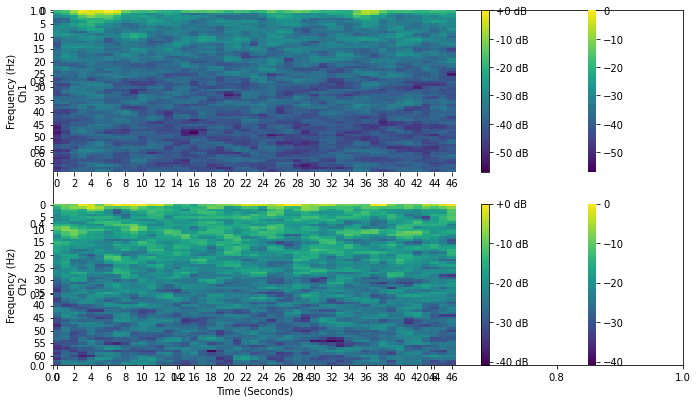

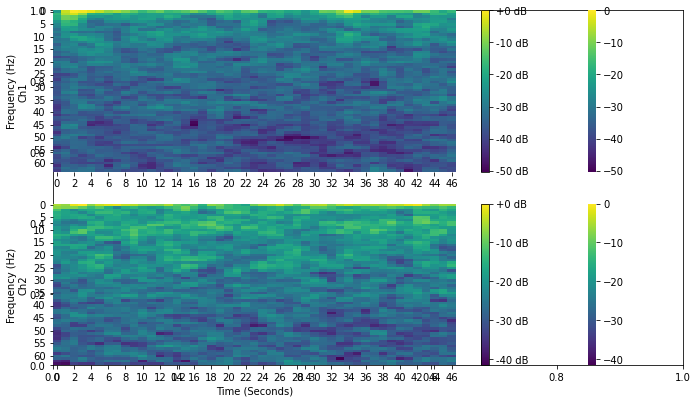

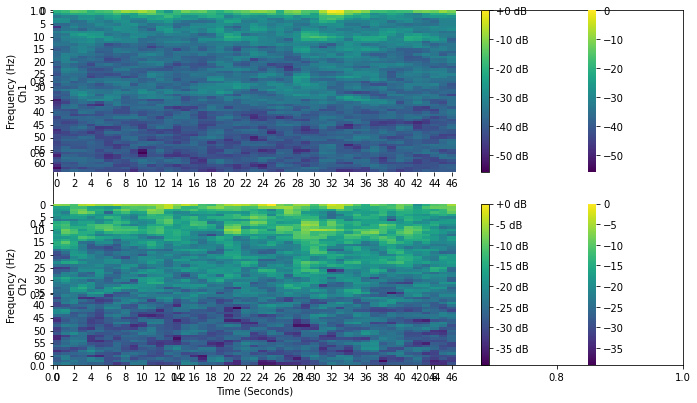

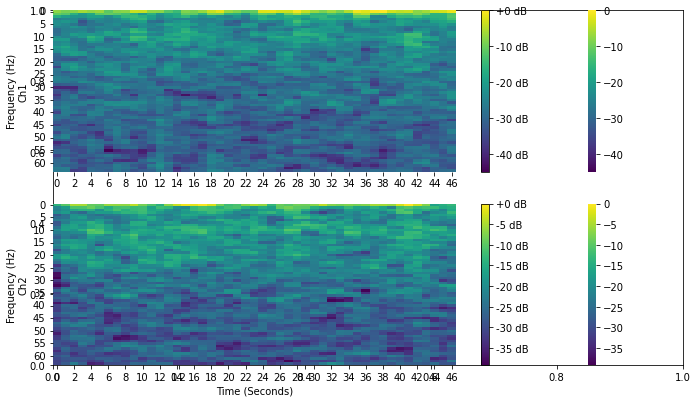

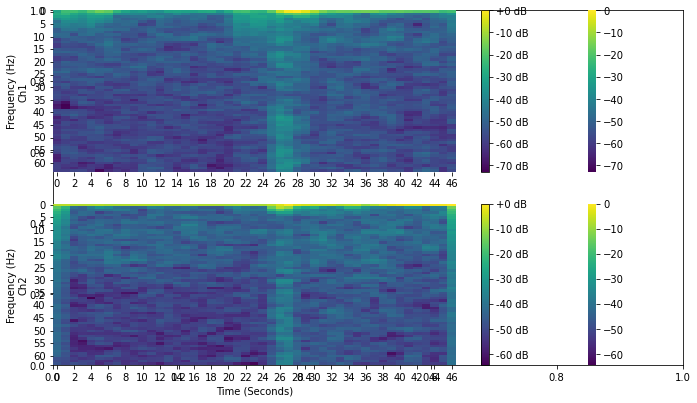

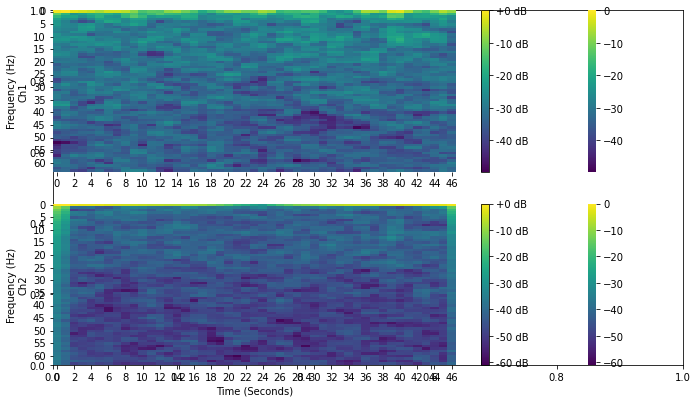

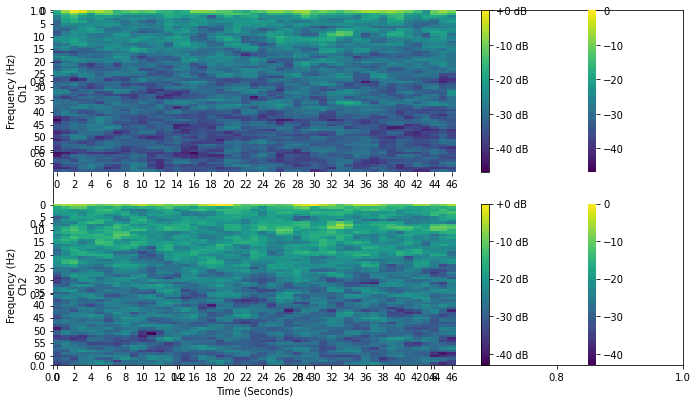

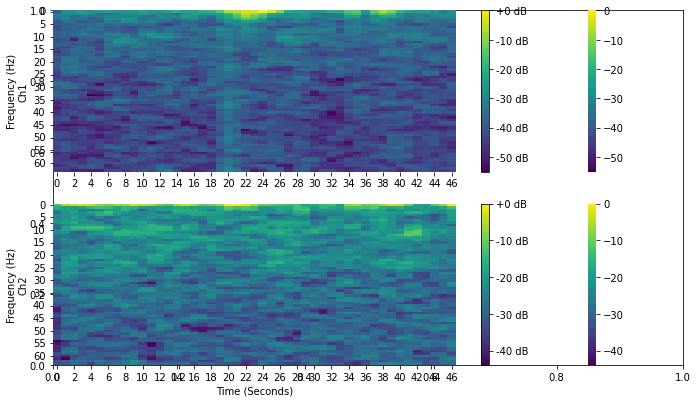

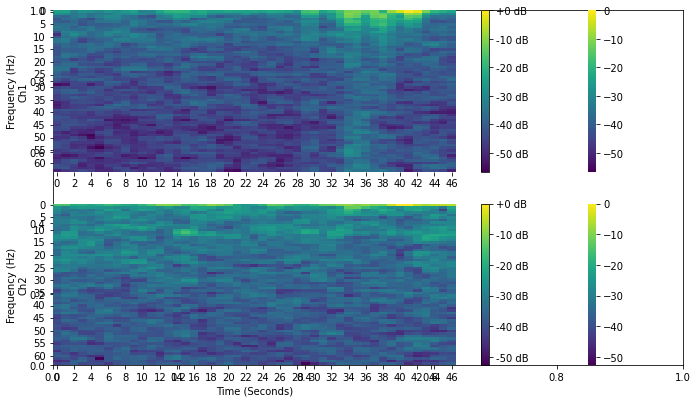

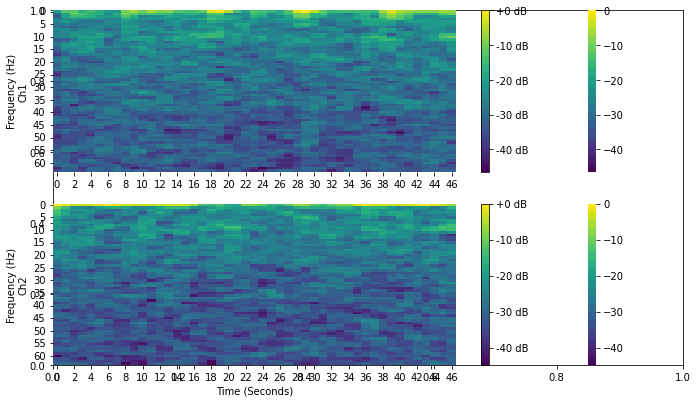

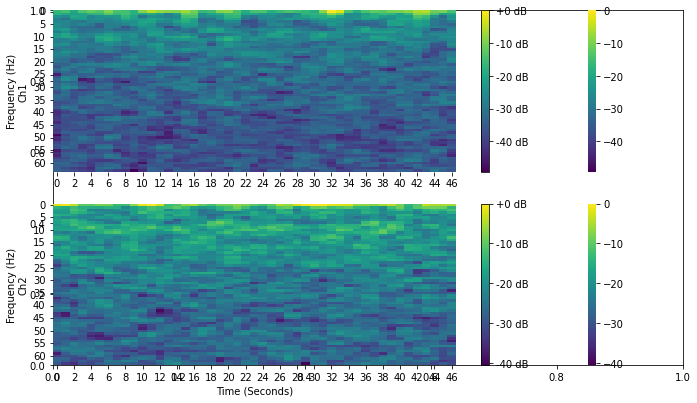

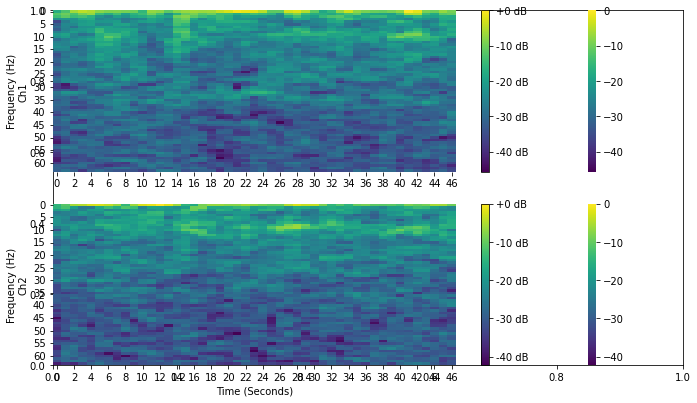

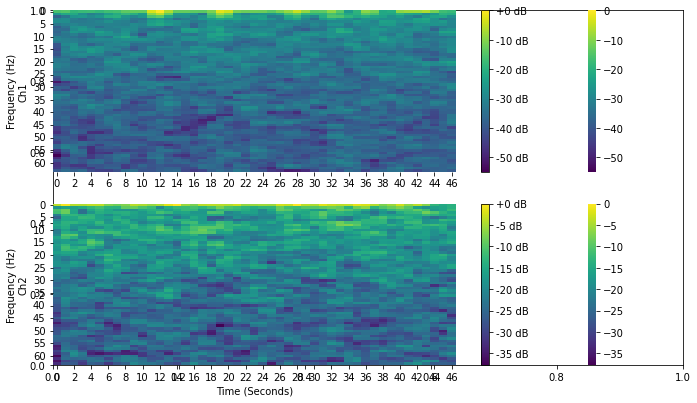

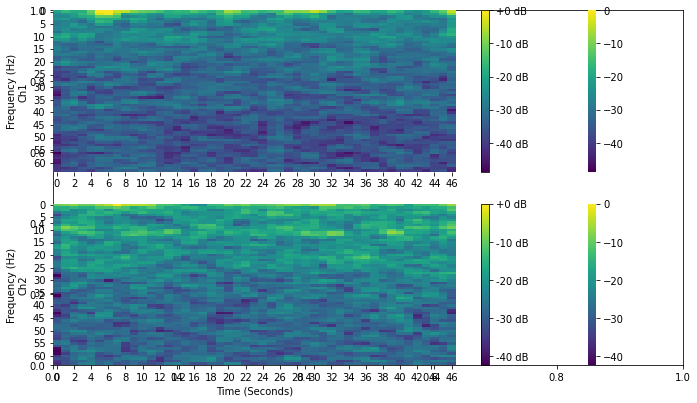

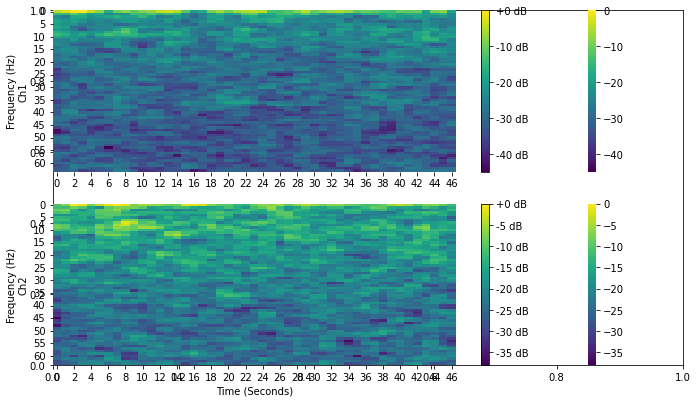

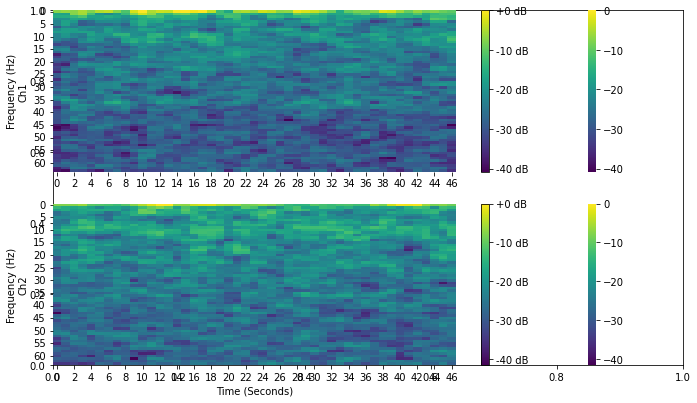

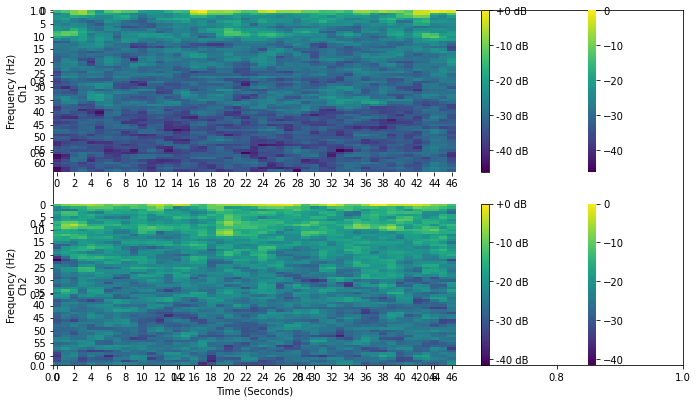

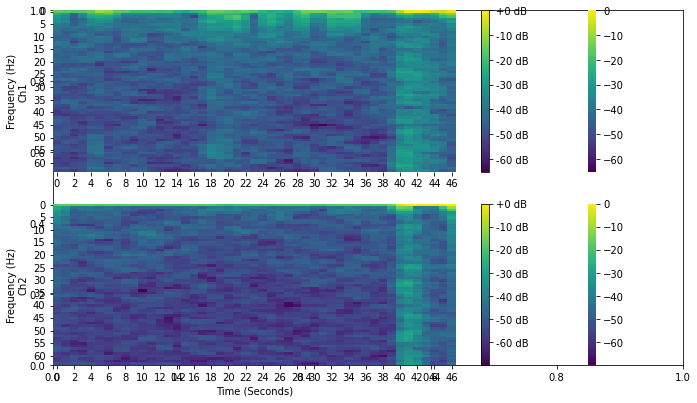

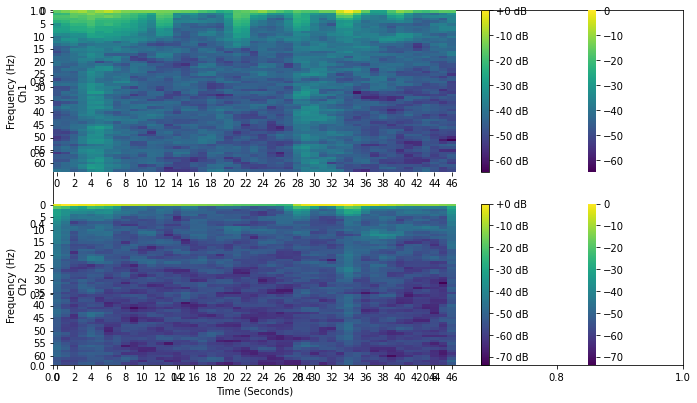

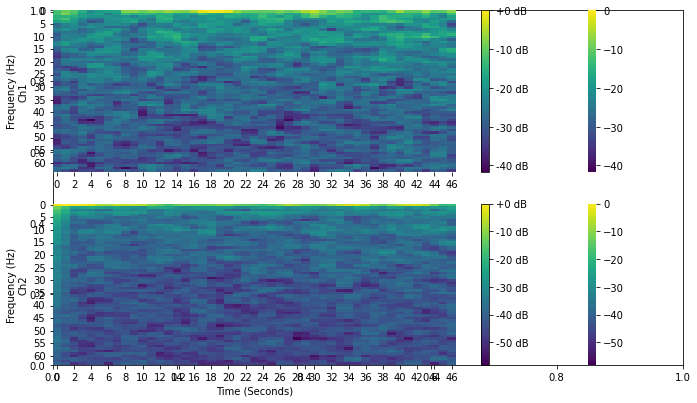

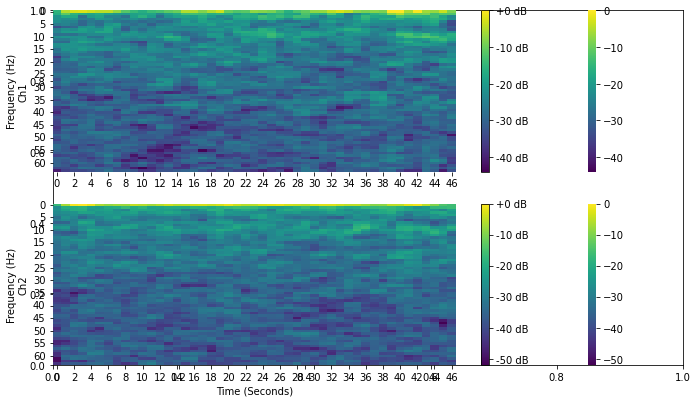

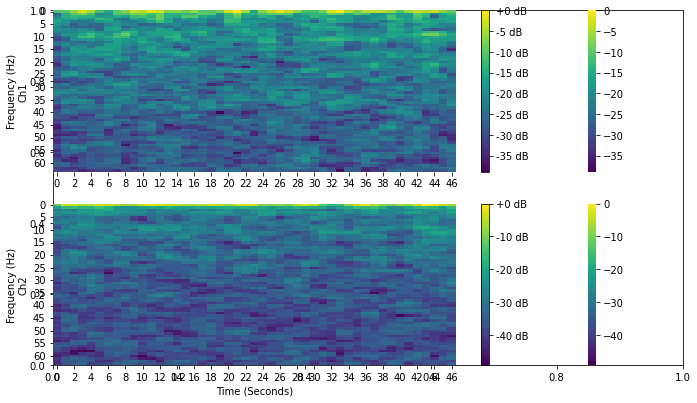

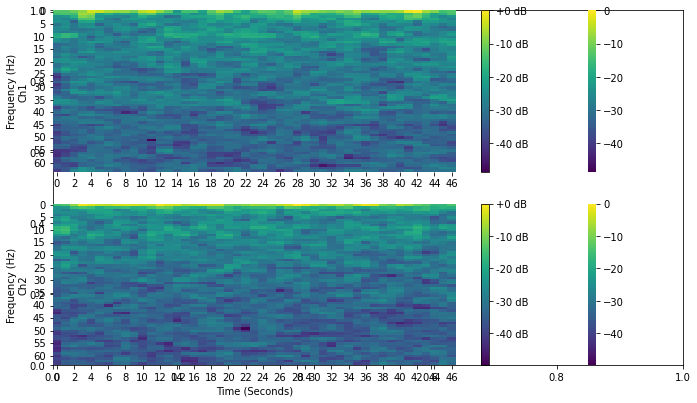

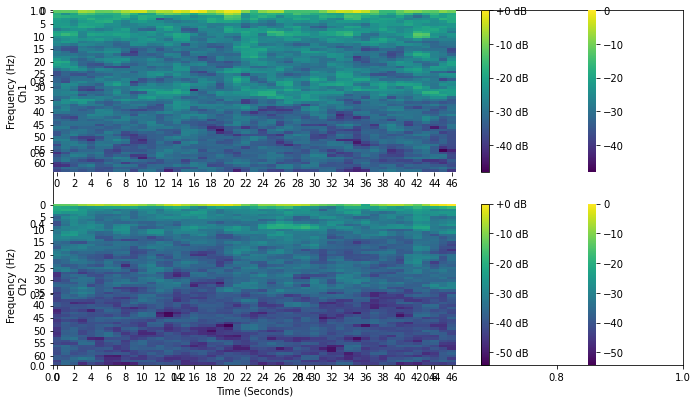

In [72]:
#random files for validation
pkl_files_val = ['data/ST7181JR.pkl', 'data/SC4352FV.pkl', 'data/SC4261FM.pkl', 'data/SC4751EC.pkl', 'data/SC4522EM.pkl', 'data/SC4121EC.pkl', 'data/SC4511EJ.pkl', 'data/SC4171EU.pkl', 'data/ST7192JR.pkl', 'data/ST7051JA.pkl', 'data/SC4381FC.pkl', 'data/SC4621EV.pkl', 'data/ST7211JJ.pkl', 'data/SC4421EA.pkl', 'data/SC4181EC.pkl', 'data/SC4481FV.pkl', 'data/SC4252EU.pkl', 'data/ST7212JJ.pkl', 'data/SC4272FM.pkl']

#random files for testing
pkl_files_test = ['data/SC4442EV.pkl', 'data/SC4412EM.pkl', 'data/SC4321EC.pkl', 'data/SC4452FW.pkl', 'data/ST7171JA.pkl', 'data/SC4262FC.pkl', 'data/SC4331FV.pkl', 'data/SC4081EC.pkl', 'data/SC4741EA.pkl', 'data/SC4091EC.pkl', 'data/SC4801GC.pkl', 'data/SC4382FW.pkl', 'data/SC4602EJ.pkl', 'data/ST7202JO.pkl', 'data/ST7152JA.pkl', 'data/SC4232EV.pkl', 'data/SC4772GC.pkl', 'data/SC4202EC.pkl', 'data/SC4342FA.pkl']

#random files for training
pkl_files_train = ['data/SC4611EG.pkl', 'data/SC4061EC.pkl', 'data/SC4021EH.pkl', 'data/SC4101EC.pkl', 'data/ST7011JP.pkl', 'data/SC4631EM.pkl', 'data/SC4402EW.pkl', 'data/SC4351FA.pkl', 'data/SC4162EC.pkl', 'data/SC4712EA.pkl', 'data/SC4062EC.pkl', 'data/SC4711EC.pkl', 'data/SC4582GP.pkl', 'data/SC4762EG.pkl', 'data/SC4722EM.pkl', 'data/ST7121JE.pkl', 'data/SC4552FW.pkl', 'data/SC4652EG.pkl', 'data/ST7222JA.pkl', 'data/SC4041EC.pkl', 'data/SC4572FC.pkl', 'data/SC4571FV.pkl', 'data/ST7101JE.pkl', 'data/SC4371FA.pkl', 'data/SC4622EJ.pkl', 'data/SC4221EJ.pkl', 'data/SC4311EC.pkl', 'data/SC4292GC.pkl', 'data/SC4051EC.pkl', 'data/SC4592GY.pkl', 'data/ST7082JW.pkl', 'data/SC4212EC.pkl', 'data/ST7012JP.pkl', 'data/SC4462FJ.pkl', 'data/SC4601EC.pkl', 'data/SC4811GG.pkl', 'data/SC4542FW.pkl', 'data/SC4661EJ.pkl', 'data/SC4541FA.pkl', 'data/SC4761EP.pkl', 'data/SC4142EU.pkl', 'data/ST7191JR.pkl', 'data/SC4651EP.pkl', 'data/SC4641EP.pkl', 'data/SC4401EC.pkl', 'data/SC4152EC.pkl', 'data/SC4422EA.pkl', 'data/ST7052JA.pkl', 'data/ST7172JA.pkl', 'data/SC4291GA.pkl', 'data/ST7081JW.pkl', 'data/SC4031EC.pkl', 'data/ST7221JA.pkl', 'data/SC4071EC.pkl', 'data/SC4312EM.pkl', 'data/SC4122EV.pkl', 'data/ST7122JE.pkl', 'data/ST7151JA.pkl', 'data/SC4491GJ.pkl', 'data/SC4242EA.pkl', 'data/SC4112EC.pkl', 'data/SC4011EH.pkl', 'data/SC4222EC.pkl', 'data/ST7072JA.pkl', 'data/SC4771GC.pkl', 'data/SC4282GC.pkl', 'data/SC4581GM.pkl', 'data/SC4362FC.pkl', 'data/SC4172EC.pkl', 'data/ST7042JO.pkl', 'data/ST7162JM.pkl', 'data/SC4591GY.pkl', 'data/ST7201JO.pkl', 'data/SC4322EC.pkl', 'data/SC4431EM.pkl', 'data/SC4281GC.pkl', 'data/SC4502EM.pkl', 'data/SC4672GV.pkl', 'data/SC4482FJ.pkl', 'data/SC4702EA.pkl', 'data/SC4131EC.pkl', 'data/SC4111EC.pkl', 'data/SC4001EC.pkl', 'data/SC4271FC.pkl', 'data/SC4662EJ.pkl', 'data/SC4201EC.pkl', 'data/ST7111JE.pkl', 'data/SC4701EC.pkl', 'data/SC4141EU.pkl', 'data/SC4822GC.pkl', 'data/SC4561FJ.pkl', 'data/SC4732EJ.pkl', 'data/SC4551FC.pkl', 'data/SC4671GJ.pkl', 'data/SC4531EM.pkl', 'data/SC4161EC.pkl', 'data/SC4501EW.pkl', 'data/SC4191EP.pkl', 'data/SC4532EV.pkl', 'data/SC4731EM.pkl', 'data/SC4251EP.pkl', 'data/SC4472FA.pkl', 'data/SC4461FA.pkl', 'data/ST7182JR.pkl', 'data/ST7041JO.pkl', 'data/SC4092EC.pkl', 'data/SC4812GV.pkl', 'data/SC4302EV.pkl', 'data/ST7242JO.pkl', 'data/SC4492GJ.pkl', 'data/SC4632EA.pkl', 'data/SC4642EP.pkl', 'data/SC4052EC.pkl', 'data/ST7091JE.pkl', 'data/SC4411EJ.pkl', 'data/ST7241JO.pkl', 'data/SC4432EM.pkl', 'data/SC4241EC.pkl', 'data/ST7112JE.pkl', 'data/SC4211EC.pkl', 'data/SC4032EP.pkl', 'data/SC4192EV.pkl', 'data/SC4451FY.pkl', 'data/SC4332FC.pkl', 'data/SC4082EP.pkl', 'data/ST7102JE.pkl', 'data/ST7062JR.pkl', 'data/SC4012EC.pkl', 'data/SC4441EC.pkl', 'data/ST7161JM.pkl', 'data/SC4802GV.pkl', 'data/SC4752EM.pkl', 'data/SC4821GC.pkl', 'data/SC4102EC.pkl', 'data/SC4042EC.pkl', 'data/SC4512EW.pkl', 'data/SC4742EC.pkl', 'data/SC4151EC.pkl', 'data/SC4471FA.pkl', 'data/SC4022EJ.pkl', 'data/SC4072EH.pkl', 'data/SC4301EC.pkl', 'data/ST7061JR.pkl', 'data/SC4372FC.pkl', 'data/SC4562FJ.pkl', 'data/SC4721EC.pkl', 'data/SC4612EA.pkl', 'data/SC4341FA.pkl', 'data/SC4182EC.pkl', 'data/SC4231EJ.pkl', 'data/SC4002EC.pkl', 'data/ST7022JM.pkl']

#do spectrogram calculations
calculate_spectrograms(pkl_files_val, 'val')
calculate_spectrograms(pkl_files_test, 'test')
calculate_spectrograms(pkl_files_train, 'train')
calculate_spectrograms(['data/ST7152JA.pkl'], 'ST7152JA')